In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import auc, precision_recall_curve, roc_curve
import torch
import torch.nn as nn
import torch_geometric as pyg
import torch_geometric.nn as gnn

/mnt/c/Users/nck/repos/GNN-Plus/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)

# Setup

## Dataset

In [3]:
loaded_data = {}
def get_data(cell_type, subset=(750, 750, 750), neg_frac=None, gene_list=None, seed=42):
    np.random.seed(seed)
    
    # Get graph
    data_folder = './data/training_matrices_DGL/'
    if cell_type in loaded_data:
        mat = loaded_data[cell_type]
    else:
        mat = pd.read_csv(data_folder + f'{cell_type}.feat.mat', index_col=0, sep='\t')
        loaded_data[cell_type] = mat
    genes = np.array(mat.columns)
    assert (genes == np.array(mat.index)).all()

    # Get labels
    meta = pd.read_csv(data_folder + 'training_labels.txt', index_col=0, sep='\t')
    labels = meta.values[:, 0]
    labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

    ### SUBSET
    if gene_list is not None:
        subset_idx = np.argwhere([g in gene_list for g in genes]).flatten()
    elif neg_frac is not None:
        ad_labels = np.argwhere(labels == 'AD').flatten()
        notad_labels = np.argwhere(labels == 'notAD').flatten()
        unknown_labels = np.argwhere(labels == 'unknown').flatten()
        subset_idx = np.concatenate([
            np.random.choice(ad_labels, len(ad_labels), replace=False),
            np.random.choice(notad_labels, neg_frac * len(ad_labels), replace=False),
            np.random.choice(unknown_labels, max(neg_frac * len(ad_labels), len(ad_labels)), replace=False)])
    elif subset is not None:
        # subset_idx = np.random.choice(len(labels), 1000, replace=False)
        ad_labels = np.argwhere(labels == 'AD').flatten()
        notad_labels = np.argwhere(labels == 'notAD').flatten()
        unknown_labels = np.argwhere(labels == 'unknown').flatten()
        subset_idx = np.concatenate([
            np.random.choice(ad_labels, min(len(ad_labels), subset[0]), replace=False),
            np.random.choice(notad_labels, min(len(notad_labels), subset[1]), replace=False),
            np.random.choice(unknown_labels, min(len(unknown_labels), subset[2]), replace=False)])
    if gene_list is not None or neg_frac is not None or subset is not None:
        mat = mat.iloc[subset_idx, subset_idx]
        genes = genes[subset_idx]
        labels = labels[subset_idx]
    ###

    # Sort labels
    ad_labels = np.argwhere(labels == 'AD').flatten()
    notad_labels = np.argwhere(labels == 'notAD').flatten()
    unknown_labels = np.argwhere(labels == 'unknown').flatten()
    known_labels = np.array(list(set(range(len(genes))) - set(unknown_labels)))
    
    # CLI out
    print(f'AD: {len(ad_labels)}; notAD: {len(notad_labels)}; unknown: {len(unknown_labels)}')

    # Split into training and testing
    train_num = int(len(genes) * .8)
    val_num = len(genes) - train_num
    train_idx = np.random.choice(len(genes), train_num, replace=False)
    val_idx = np.array(list(set(range(len(genes))) - set(train_idx)))

    # Masks
    train_mask = [i in train_idx for i in range(len(genes))]
    val_mask = [i in val_idx for i in range(len(genes))]

    # Format sparse
    mat.values[np.eye(mat.values.shape[0] ,dtype=bool)] = 0  # Remove diagonal
    mat = scipy.sparse.coo_matrix(mat.values)
    edge_indices = np.stack([mat.row, mat.col])
    edge_indices = np.concatenate([edge_indices, edge_indices[::-1]], axis=1)  # Make undirected
    edge_weights = np.concatenate([mat.data, mat.data])

    # Construct dataset
    data = pyg.data.Data(
        num_nodes=len(labels),
        node_name=genes,
        y=labels,
        edge_index=torch.tensor(edge_indices).to(torch.int64),
        edge_weight=torch.tensor(edge_weights).to(torch.float64),
        train_mask=train_mask,
        val_mask=val_mask)
    
    return (data, genes), (train_idx, val_idx), (labels, ad_labels, notad_labels, unknown_labels, known_labels)

# Example dataset
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid('./data', 'Cora')[0]
# dataset
# row, col = data.edge_index
# print(col.dtype)
# row, col = dataset.edge_index
# print(col.dtype)

## Embedding Model

In [4]:
# Train model
def train(model, loader, optimizer):
    epoch_loss = 0
    for pos, neg in loader:
        loss = model.loss(pos, neg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()
        
    return epoch_loss / len(loader)

## AD Prediction

In [5]:
# Create model
class FCL(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fcl = nn.Linear(self.input_dim, self.output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        return self.sigmoid(self.fcl(X))

# Train model
def train_ad(ad_model, ad_optimizer, ad_criterion, z):
    batch_size = 128
    batches = data.edge_index.shape[1] // batch_size
    epoch_loss = 0
    for j in range(batches):
        seg_size = int(batch_size / 2)
        ad_batch_idx = np.random.choice(np.intersect1d(ad_labels, train_idx), seg_size, replace=True)
        notad_batch_idx = np.random.choice(np.intersect1d(notad_labels, train_idx), seg_size, replace=True)
        batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])

        true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
        logits = ad_model(z[batch_idx])
        loss = ad_criterion(logits, true)
        loss.backward()
        ad_optimizer.step()
        epoch_loss += loss.detach()
    epoch_loss /= batches
    
    return epoch_loss

## Training

In [6]:
def generate_models(threshold=.3):
    # Construct model
    embedding_dim = 16
    model = gnn.Node2Vec(
        data.edge_index[:, data.edge_weight > threshold],
        embedding_dim=embedding_dim,
        walk_length=20,
        context_size=10,
        walks_per_node=10,
        num_negative_samples=1,
        p=1,
        q=1,
        num_nodes=len(data.y),
        sparse=True)
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=1e-2)

    # Train embeddings
    print('Generating embeddings...')
    model.train()
    for i in range(21):
        epoch_loss = train(model, loader, optimizer)
        if i % 2 == 0:
            print(f'Epoch {i} Loss: {epoch_loss:.3f}')
    model.eval()

    # Construct AD Model (NN)
    ad_model = FCL(embedding_dim)
    ad_optimizer = torch.optim.Adam(ad_model.parameters(), lr=1e-2)
    ad_criterion = nn.MSELoss()

    # Train AD Model (NN)
    print('Training AD classification model...')
    z = model()
    ad_model.train()
    for i in range(61):
        epoch_loss = train_ad(ad_model, ad_optimizer, ad_criterion, z)
        if i % 10 == 0:
            print(f'Epoch {i} Loss: {epoch_loss:.3f}')
    ad_model.eval()
    
    # # Construct AD Model (Logistic Regression)
    # z = model().detach().numpy()
    # ad_model = LogisticRegression(solver='lbfgs', multi_class='auto').fit(
    #     z[np.intersect1d(np.union1d(ad_labels, notad_labels), train_idx)],
    #     np.concatenate([np.ones(len(np.intersect1d(ad_labels, train_idx))), np.zeros(len(np.intersect1d(notad_labels, train_idx)))]))
    
    return model, ad_model

## Results

In [7]:
def preview_ad():
    # Predictions
    pred_val = ad_model(model())
    pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])

    # Printout
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(np.intersect1d(ad_labels, val_idx), 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tAD')
    print()
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(np.intersect1d(notad_labels, val_idx), 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tnotAD')
    print()
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(unknown_labels, 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tunknown')

def write_predictions(prefix='./'):
    # Predictions
    pred_val = ad_model(model())
    pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])
    
    # Write enrichment genes to files
    ad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'AD'), val_idx)]
    notad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'notAD'), val_idx)]
    np.savetxt(prefix + 'AD.txt', ad_enrichment, fmt='%s')
    np.savetxt(prefix + 'notAD.txt', notad_enrichment, fmt='%s')

In [8]:
def get_auroc():
    # Predictions
    pred_val = ad_model(model())
    
    # ROC
    eval_idx = np.intersect1d(val_idx, known_labels)
    fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    
    return auc(fpr, tpr)

def get_auprc():
    # Predictions
    pred_val = ad_model(model())
    
    # PRC
    eval_idx = np.intersect1d(val_idx, known_labels)
    prec, rec, thresholds = precision_recall_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    
    return auc(rec, prec)

def plot_roc():
    # Predictions
    pred_val = ad_model(model())
    
    # ROC Curve
    eval_idx = np.intersect1d(val_idx, known_labels)
    fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve ({auc(fpr, tpr)})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# Runtime

In [9]:
folds = 5

In [10]:
cell_types = np.array([f[:-9] for f in os.listdir('./data/training_matrices_DGL') if '.mat' in f])
auroc_list, auprc_list = [], []
for i, cell_type in enumerate(cell_types):
    auroc_list.append([])
    auprc_list.append([])
    for k in range(folds):  # Folds
        # Set up dir
        if not os.path.exists('results/'):
            os.mkdir('results/')
        if i == 0:
            open('results/auroc.txt', 'w').close()
            open('results/auprc.txt', 'w').close()
        if not os.path.exists(f'results/{cell_type}'):
            os.mkdir(f'results/{cell_type}')
        if not os.path.exists(f'results/{cell_type}/fold{k}'):
            os.mkdir(f'results/{cell_type}/fold{k}')
        results_dir = f'results/{cell_type}/fold{k}/'

        # Get data
        print(f'Loading {cell_type} data...')
        dataset = get_data(cell_type, neg_frac=1)
        data, genes = dataset[0]
        train_idx, val_idx = dataset[1]
        labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]
        np.savetxt(results_dir + 'genes.txt', genes, fmt='%s')

        # Train models
        if os.path.exists(results_dir + 'model.h5') and os.path.exists(results_dir + 'ad_model.h5'):
            print('Loading pre-trained models...')
            model = torch.load(results_dir + 'model.h5')
            ad_model = torch.load(results_dir + 'ad_model.h5')
        else:
            model, ad_model = generate_models()
            np.save(results_dir + 'embeddings.npy', model().detach().numpy())
            torch.save(model, results_dir + 'model.h5')
            torch.save(ad_model, results_dir + 'ad_model.h5')

        # Save results
        write_predictions(prefix=results_dir)
        auroc_list[-1].append(get_auroc())
        print(f'{cell_type} (fold {k}) AUROC: {auroc_list[-1][-1]:.3f}')
        with open('results/auroc.txt', 'a') as f:
            f.write(f'{cell_type} (fold {k}) AUROC: {auroc_list[-1][-1]:.3f}\n')
        auprc_list[-1].append(get_auprc())
        print(f'{cell_type} (fold {k}) AUPRC: {auprc_list[-1][-1]:.3f}')
        with open('results/auprc.txt', 'a') as f:
            f.write(f'{cell_type} (fold {k}) AUPRC: {auprc_list[-1][-1]:.3f}\n')
        print()
auroc_list = np.array(auroc_list)
auprc_list = np.array(auprc_list)

Loading Astrocyte data...
AD: 121; notAD: 121; unknown: 121
Generating embeddings...
Epoch 0 Loss: 3.067
Epoch 2 Loss: 2.811
Epoch 4 Loss: 2.577
Epoch 6 Loss: 2.352
Epoch 8 Loss: 2.157
Epoch 10 Loss: 1.963
Epoch 12 Loss: 1.807
Epoch 14 Loss: 1.668
Epoch 16 Loss: 1.538
Epoch 18 Loss: 1.449
Epoch 20 Loss: 1.364
Training AD classification model...
Epoch 0 Loss: 0.303
Epoch 10 Loss: 0.294
Epoch 20 Loss: 0.294
Epoch 30 Loss: 0.288
Epoch 40 Loss: 0.286
Epoch 50 Loss: 0.285
Epoch 60 Loss: 0.286
Astrocyte (fold 0) AUROC: 0.518
Astrocyte (fold 0) AUPRC: 0.601

Loading Astrocyte data...
AD: 121; notAD: 121; unknown: 121
Generating embeddings...
Epoch 0 Loss: 2.969
Epoch 2 Loss: 2.719
Epoch 4 Loss: 2.494
Epoch 6 Loss: 2.273
Epoch 8 Loss: 2.082
Epoch 10 Loss: 1.908
Epoch 12 Loss: 1.753
Epoch 14 Loss: 1.615
Epoch 16 Loss: 1.509
Epoch 18 Loss: 1.416
Epoch 20 Loss: 1.339
Training AD classification model...
Epoch 0 Loss: 0.277
Epoch 10 Loss: 0.284
Epoch 20 Loss: 0.267
Epoch 30 Loss: 0.248
Epoch 40 Los

# Analysis

## Performance Metrics

In [441]:
# Convert to pandas df
df = pd.DataFrame(data={
    'cell_type': np.concatenate([folds*[ct] for ct in cell_types]),
    'fold': np.concatenate([list(range(folds)) for i in cell_types]),
    'auroc': np.concatenate(auroc_list),
    'auprc': np.concatenate(auprc_list),
})
sns.set_style('white')
# https://stackoverflow.com/a/65529178
style = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

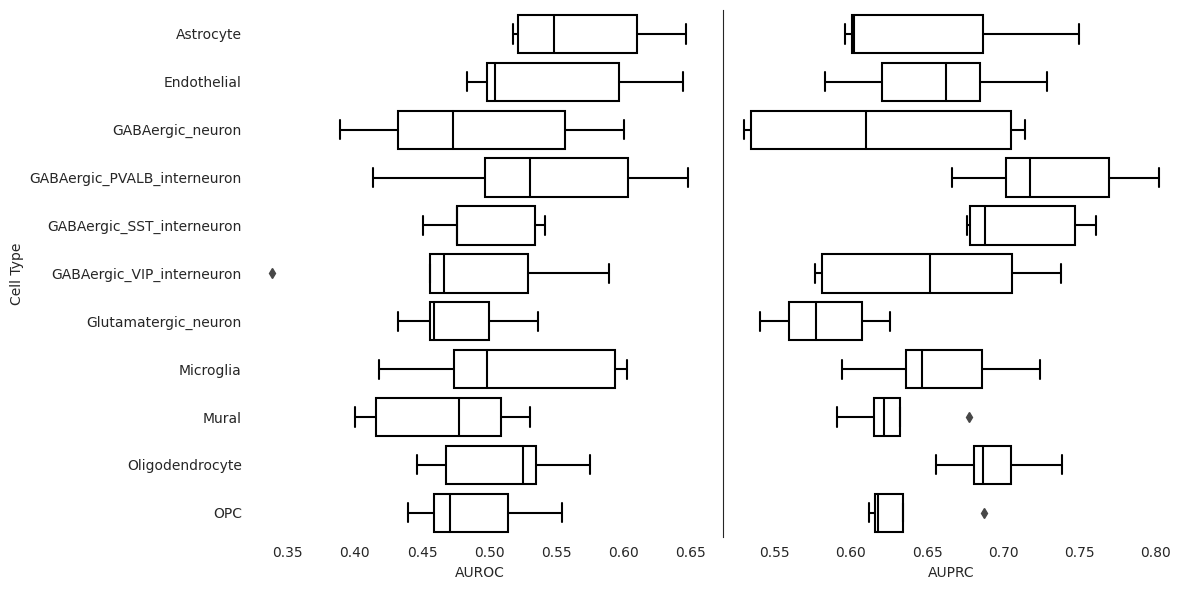

In [459]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# Barplot
sns.boxplot(ax=axs[0], data=df, x='auroc', y='cell_type', **style)
sns.despine(ax=axs[0], left=True, bottom=True)
sns.boxplot(ax=axs[1], data=df, x='auprc', y='cell_type', **style)
sns.despine(ax=axs[1], left=False, bottom=True)
# Labels
axs[0].set_xlabel('AUROC')
axs[0].set_ylabel('Cell Type')
axs[1].set_xlabel('AUPRC')
axs[1].set_ylabel(None)
plt.tight_layout()
# Save figure
plt.savefig('results/performance.png', dpi=300, bbox_inches='tight')

## Graphs

In [460]:
import hiveplotlib as hpl
from hiveplotlib import Axis, Node, HivePlot
from hiveplotlib.converters import networkx_to_nodes_edges
from hiveplotlib.viz import axes_viz_mpl, node_viz_mpl, edge_viz_mpl

# Get best model
best_performing_model = np.argmax(np.concatenate(auprc_list))
print(f'Best performing model: {cell_types[best_performing_model // folds]} ({auprc_list[best_performing_model // folds][best_performing_model % folds]:.3f})')
cell_type = cell_types[best_performing_model // folds]
results_dir = f'results/{cell_type}/fold{best_performing_model % folds}/'
ad_genes = np.loadtxt(results_dir + 'AD.txt', dtype=str)
notad_genes = np.loadtxt(results_dir + 'notAD.txt', dtype=str)
genes = list(set(ad_genes) | set(notad_genes))

Best performing model: GABAergic_PVALB_interneuron (0.802)


### Base Data

In [461]:
dataset = get_data(cell_type, gene_list=genes)
data, genes = dataset[0]
train_idx, val_idx = dataset[1]
labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]

# Create graph
graph = pyg.utils.convert.to_networkx(data, node_attrs=['node_name'], edge_attrs=['edge_weight'], to_undirected=True)
graph = nx.relabel_nodes(graph, lambda x: graph.nodes(data=True)[x]['node_name'], copy=False)

# Hiveplot
nodes, edges = hpl.converters.networkx_to_nodes_edges(graph)

# Import node data
# Add label
deg_cen = nx.degree_centrality(graph)
eig_cen = nx.eigenvector_centrality(graph)
clo_cen = nx.closeness_centrality(graph)
bet_cen = nx.betweenness_centrality(graph)
for node in nodes:
    deg = deg_cen[node.data['node_name']]
    eig = eig_cen[node.data['node_name']]
    clo = clo_cen[node.data['node_name']]
    bet = bet_cen[node.data['node_name']]
    node.add_data(data=dict(deg=deg, eig=eig, clo=clo, bet=bet))

AD: 29; notAD: 18; unknown: 24


In [462]:
def plot_hp(subset=genes, ax=None):
    # Vizualize
    hp = HivePlot()
    hp.add_nodes(nodes)

    # Axes
    axis0 = Axis(axis_id='deg', start=1, end=5, angle=30, long_name='Degree')
    axis1 = Axis(axis_id='eig', start=1, end=5, angle=150, long_name='Eigenvector')
    axis2 = Axis(axis_id='bet', start=1, end=5, angle=270, long_name='Betweenness')
    axes = [axis0, axis1, axis2]
    hp.add_axes(axes)

    # Nodes
    all_nodes = subset
    hp.place_nodes_on_axis(axis_id='deg', unique_ids=all_nodes, sorting_feature_to_use='deg', vmin=min(deg_cen.values()), vmax=max(deg_cen.values()))
    hp.place_nodes_on_axis(axis_id='eig', unique_ids=all_nodes, sorting_feature_to_use='eig', vmin=min(eig_cen.values()), vmax=max(eig_cen.values()))
    hp.place_nodes_on_axis(axis_id='bet', unique_ids=all_nodes, sorting_feature_to_use='bet', vmin=min(bet_cen.values()), vmax=max(bet_cen.values()))

    # Edges
    hp.connect_axes(edges=edges, axis_id_1='deg', axis_id_2='eig', color='black')
    hp.connect_axes(edges=edges, axis_id_1='eig', axis_id_2='bet', color='black')
    hp.connect_axes(edges=edges, axis_id_1='bet', axis_id_2='deg', color='black')

    # Plot
    if ax is None:
        fig, ax = axes_viz_mpl(hp)
        plt.tight_layout()
    else:
        fig = ax.get_figure()
        axes_viz_mpl(hp, fig=fig, ax=ax)
    # node_viz_mpl(hp, fig=fig, ax=ax, s=5, color='black')
    edge_viz_mpl(hp, fig=fig, ax=ax, alpha=1., zorder=-1, linewidth=1/len(subset))

    # Mark Nodes
    for hp_ax in hp.axes.values():
        locations = hp_ax.node_placements
        ad_locations_mask = np.array([g in genes[ad_labels] for g in locations.loc[:, 'unique_id']])
        notad_locations_mask = np.array([g in genes[notad_labels] for g in locations.loc[:, 'unique_id']])
        for x, y in list(locations.loc[ad_locations_mask, ['x', 'y']].values):
            ax.scatter(x, y, color='red', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=4)
        for x, y in list(locations.loc[notad_locations_mask, ['x', 'y']].values):
            ax.scatter(x, y, color='teal', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=3)
        for x, y in list(locations.loc[~(ad_locations_mask + notad_locations_mask), ['x', 'y']].values):
            ax.scatter(x, y, color='black', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=2)

In [463]:
def plot_hp_pred(subset=genes, ax=None):
    # Vizualize
    hp = HivePlot()
    hp.add_nodes(nodes)

    # Axes
    deviation = 20
    axis0 = Axis(axis_id='tn', start=1, end=5, angle=deviation, long_name='True Not AD')
    axis1 = Axis(axis_id='pn', start=1, end=5, angle=-deviation, long_name='Predicted Not AD')
    axis2 = Axis(axis_id='ta', start=1, end=5, angle=180-deviation, long_name='True AD')
    axis3 = Axis(axis_id='pa', start=1, end=5, angle=180+deviation, long_name='Predicted AD')
    axes = [axis0, axis1, axis2, axis3]
    hp.add_axes(axes)

    # Nodes
    true_ad = genes[ad_labels]
    true_notad = genes[notad_labels]
    pred_ad = ad_genes
    pred_notad = notad_genes
    sf = 'deg'; sf_raw = deg_cen
    hp.place_nodes_on_axis(axis_id='tn', unique_ids=true_notad, sorting_feature_to_use=sf, vmin=min(sf_raw.values()), vmax=max(sf_raw.values()))
    hp.place_nodes_on_axis(axis_id='pn', unique_ids=pred_notad, sorting_feature_to_use=sf, vmin=min(sf_raw.values()), vmax=max(sf_raw.values()))
    hp.place_nodes_on_axis(axis_id='ta', unique_ids=true_ad, sorting_feature_to_use=sf, vmin=min(sf_raw.values()), vmax=max(sf_raw.values()))
    hp.place_nodes_on_axis(axis_id='pa', unique_ids=pred_ad, sorting_feature_to_use=sf, vmin=min(sf_raw.values()), vmax=max(sf_raw.values()))

    # Edges
    hp.connect_axes(edges=edges, axis_id_1='tn', axis_id_2='pn', color='black')
    hp.connect_axes(edges=edges, axis_id_1='ta', axis_id_2='pa', color='black')
    hp.connect_axes(edges=edges, axis_id_1='ta', axis_id_2='tn', color='black')
    hp.connect_axes(edges=edges, axis_id_1='pa', axis_id_2='pn', color='black')

    # Plot
    if ax is None:
        fig, ax = axes_viz_mpl(hp)
        plt.tight_layout()
    else:
        fig = ax.get_figure()
        axes_viz_mpl(hp, fig=fig, ax=ax)
    # node_viz_mpl(hp, fig=fig, ax=ax, s=5, color='black')
    edge_viz_mpl(hp, fig=fig, ax=ax, alpha=1., zorder=-1, linewidth=1/len(subset))

    # Mark Nodes
    for hp_ax in hp.axes.values():
        locations = hp_ax.node_placements
        ad_locations_mask = np.array([g in genes[ad_labels] for g in locations.loc[:, 'unique_id']])
        notad_locations_mask = np.array([g in genes[notad_labels] for g in locations.loc[:, 'unique_id']])
        for x, y in list(locations.loc[ad_locations_mask, ['x', 'y']].values):
            ax.scatter(x, y, color='red', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=4)
        for x, y in list(locations.loc[notad_locations_mask, ['x', 'y']].values):
            ax.scatter(x, y, color='teal', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=3)
        for x, y in list(locations.loc[~(ad_locations_mask + notad_locations_mask), ['x', 'y']].values):
            ax.scatter(x, y, color='black', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=2)

In [464]:
%%capture
from matplotlib.lines import Line2D

# Legend
legend = [
    Line2D([], [], markerfacecolor='red', markeredgecolor='red', marker=(2, 0, 20), linestyle='None', markersize=10),
    Line2D([], [], markerfacecolor='teal', markeredgecolor='teal', marker=(2, 0, 20), linestyle='None', markersize=10),
    Line2D([], [], markerfacecolor='teal', markeredgecolor='black', marker=(2, 0, 20), linestyle='None', markersize=10),
    Line2D([], [], color=f'black', lw=1, linestyle='-')]
legend_names = ['AD Genes', 'Non-AD Genes', 'Unknown Genes', 'Coregulation']

# Plot legend
fig, ax = plt.subplots()
legend = ax.legend(legend, legend_names, loc='center', frameon=False, ncol=len(legend)//1)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.tight_layout()
plt.savefig('results/fig_legend.png', bbox_inches=bbox, dpi=300)

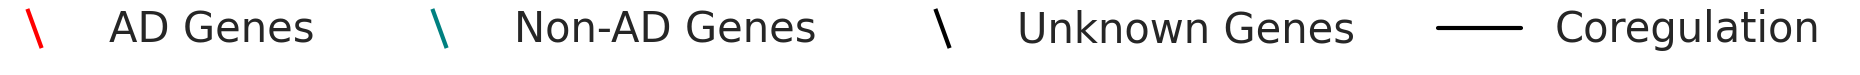

In [465]:
# Preview
from IPython.display import display, Image
display( Image(filename='results/fig_legend.png', width=800) )

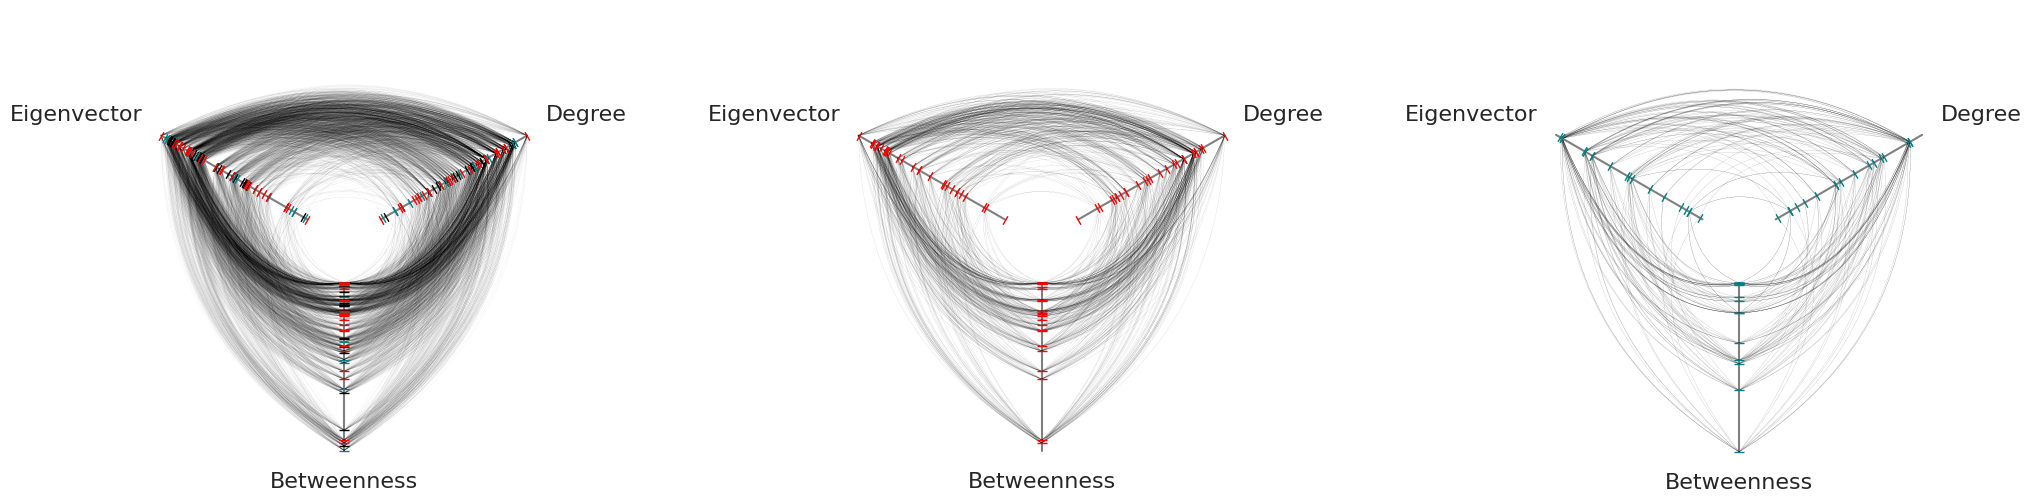

In [466]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
axs = axs.flatten()
plot_hp(subset=genes, ax=axs[0])
plot_hp(subset=genes[ad_labels], ax=axs[1])
plot_hp(subset=genes[notad_labels], ax=axs[2])
plt.subplots_adjust(wspace=.5, hspace=0.)
plt.savefig('results/fig_data.png', dpi=300, bbox_inches='tight')

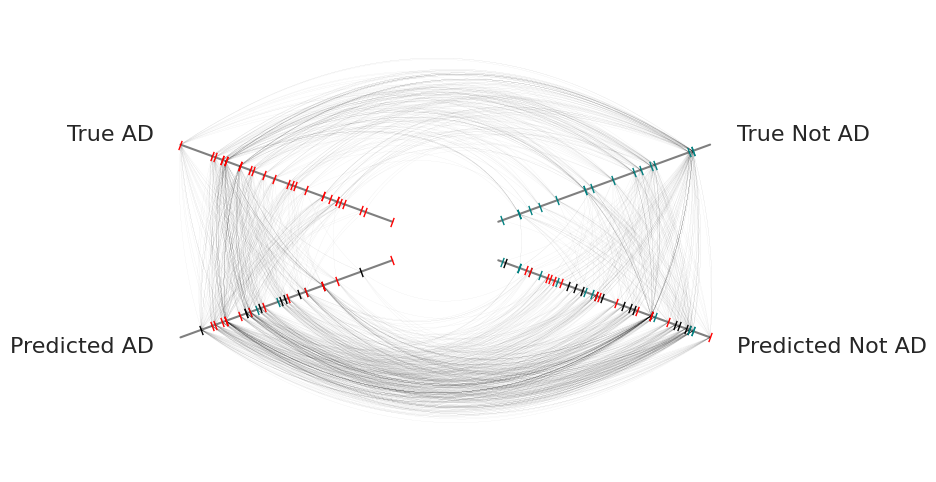

In [467]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_hp_pred(subset=genes, ax=ax)
plt.savefig('results/fig_prediction.png', dpi=300, bbox_inches='tight')

## Common AD

In [73]:
import itertools

# Find common AD genes
gene_counts = {}
for cell_type, k in itertools.product(cell_types, range(folds)):
    results_dir = f'results/{cell_type}/fold{k}/'
    # Add AD genes
    for g in np.loadtxt(results_dir + 'AD.txt', dtype=str):
        if g not in gene_counts:
            gene_counts[g] = 0
        gene_counts[g] += 1
    # Add notAD genes
    for g in np.loadtxt(results_dir + 'notAD.txt', dtype=str):
        if g not in gene_counts:
            gene_counts[g] = 0
filtered_ad_genes = [g for g, v in gene_counts.items() if v > 1]
filtered_strongad_genes = [g for g, v in gene_counts.items() if v > 5]
filtered_notad_genes = [g for g, v in gene_counts.items() if v <= 1]
np.savetxt('results/commonAD.txt', filtered_ad_genes, fmt='%s')
np.savetxt('results/commonstrongAD.txt', filtered_strongad_genes, fmt='%s')
np.savetxt('results/commonnotAD.txt', filtered_notad_genes, fmt='%s')